<a href="https://www.kaggle.com/code/awesomeharris/ps3e15-feature-imputation-with-heat-flux-dataset?scriptVersionId=130488234" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Feature Imputation with a Heat Flux Dataset

# Getting started

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Function to create scrollable table within a small window
def create_scrollable_table(df, table_id, title):
    html = f'<h3>{title}</h3>'
    html += f'<div id="{table_id}" style="height:200px; overflow:auto;">'
    html += df.to_html()
    html += '</div>'
    return html

# Import datasets

In [3]:
path1 = '/kaggle/input/predicting-heat-flux/'
'''/kaggle/input/predicting-heat-flux/'''
path2 = '/kaggle/input/playground-series-s3e15/'
'''/kaggle/input/playground-series-s3e15/'''

ori = pd.read_csv(path1+'Data_CHF_Zhao_2020_ATE.csv')
df = pd.read_csv(path2+'data.csv')
sample_sub = pd.read_csv(path2+'sample_submission.csv')

# Rename columns

This step is needed because libraries like XGB cannot recognize feature names with symbols such as [ , ] or < otherwise the following error will occur:  
       *ValueError: feature_names must be string, and may not contain [, ] or <*

In [4]:
def rename(df):
    df.rename(columns={'pressure [MPa]':'pressure',
                       'mass_flux [kg/m2-s]':'mass_flux',
                       'x_e_out [-]':'x_e_out', 
                       'D_e [mm]':'D_e', 
                       'D_h [mm]':'D_h', 
                       'length [mm]':'length',
                       'chf_exp [MW/m2]':'chf_exp'}, inplace=True)
rename(ori)
rename(df)
rename(sample_sub)
df.columns,ori.columns,sample_sub.columns

(Index(['id', 'author', 'geometry', 'pressure', 'mass_flux', 'x_e_out', 'D_e',
        'D_h', 'length', 'chf_exp'],
       dtype='object'),
 Index(['id', 'author', 'geometry', 'pressure', 'mass_flux', 'x_e_out', 'D_e',
        'D_h', 'length', 'chf_exp'],
       dtype='object'),
 Index(['id', 'x_e_out'], dtype='object'))

# Exploratory Data Analysis

## Data Summary

In [5]:
def basic_info(df, name):

    print('Shape of',name,'is',df.shape)
    print('Any null values in',name,'?',df.isnull().any().any())
    print('Number of duplicates',df.duplicated().sum(),"\n")
    
basic_info(ori, "original dataframe")
basic_info(df, "data.csv dataframe")
basic_info(sample_sub, "sample_submission.csv dataframe")

Shape of original dataframe is (1865, 10)
Any null values in original dataframe ? False
Number of duplicates 0 

Shape of data.csv dataframe is (31644, 10)
Any null values in data.csv dataframe ? True
Number of duplicates 0 

Shape of sample_submission.csv dataframe is (10415, 2)
Any null values in sample_submission.csv dataframe ? False
Number of duplicates 0 



In [6]:
def summary(df, name):
    print(f"Head of the '{name}' dataframe:")
    display(df.head())
    
    print(f"Summary of the '{name}' dataframe: \n---->  {df.shape[1]-1} features and {df.shape[0]} examples.")
    summary = pd.DataFrame(index=df.columns)
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summary["Count"] = desc['count'].values.astype(int)
    summary["Unique"] = df.nunique().values
    summary["Null Count"] = df.isnull().sum().values
    summary["Null (%)"] = (df.isnull().sum().values / df.shape[0] * 100).round(1)
    summary["Duplicated"] = df.duplicated().sum()
    summary['Std'] = np.array([round(val, 1) for val in desc['std'].values.tolist()])
    summary["Mode"] = df.mode().values[0]
    summary["Median"] = df.median().round(1)
    summary['Mean'] = np.array([round(val, 1) for val in desc['mean'].values.tolist()])
    summary['Min'] = np.array([round(val, 1) for val in desc['min'].values.tolist()])
    summary['Max'] = np.array([round(val, 1) for val in desc['max'].values.tolist()])
    summary["First Value"] = df.loc[0].values
    summary["Last Value"] = df.loc[df.shape[0]-1].values
    summary["Types"] = df.dtypes
    
    return display(summary)

print("\n=========================================================================================================================="), \
summary(ori, "ori"), \
print("=========================================================================================================================="), \
summary(df, "df"), \
print("=========================================================================================================================="), \
summary(sample_sub, "sample_sub")


Head of the 'ori' dataframe:


,id,author,geometry,pressure,mass_flux,x_e_out,D_e,D_h,length,chf_exp
0,1,Inasaka,tube,0.39,5600,-0.1041,3.0,3.0,100,11.3
1,2,Inasaka,tube,0.31,6700,-0.0596,3.0,3.0,100,10.6
2,3,Inasaka,tube,0.33,4300,-0.0395,3.0,3.0,100,7.3
3,4,Inasaka,tube,0.62,6400,-0.1460,3.0,3.0,100,12.8
4,5,Inasaka,tube,0.64,4700,-0.0849,3.0,3.0,100,11.0


Summary of the 'ori' dataframe: 
---->  9 features and 1865 examples.


,Count,Unique,Null Count,Null (%),Duplicated,Std,Mode,Median,Mean,Min,Max,First Value,Last Value,Types
id,1865,1865,0,0.0,0,538.5,1,933.0,933.0,1.0,1865.0,1,1865,int64
author,1865,10,0,0.0,0,NaN,Thompson,NaN,NaN,NaN,NaN,Inasaka,Richenderfer,object
geometry,1865,3,0,0.0,0,NaN,tube,NaN,NaN,NaN,NaN,tube,plate,object
pressure,1865,114,0,0.0,0,4.3,13.79,10.3,10.0,0.1,20.7,0.39,1.01,float64
mass_flux,1865,578,0,0.0,0,1656.4,4069.0,2590.0,2862.6,0.0,7975.0,5600,2000,int64
x_e_out,1865,1360,0,0.0,0,0.1,0.0145,0.0,0.0,-0.9,0.2,-0.1041,-0.0434,float64
D_e,1865,36,0,0.0,0,6.3,7.7,8.5,9.4,1.0,37.5,3.0,15.0,float64
D_h,1865,41,0,0.0,0,21.2,7.7,10.3,16.2,1.0,120.0,3.0,120.0,float64
length,1865,54,0,0.0,0,726.7,457.0,625.0,911.3,10.0,3048.0,100,10,int64
chf_exp,1865,109,0,0.0,0,2.0,2.3,3.5,3.9,0.8,19.3,11.3,11.5,float64


Head of the 'df' dataframe:


,id,author,geometry,pressure,mass_flux,x_e_out,D_e,D_h,length,chf_exp
0,0,Thompson,tube,7.00,3770.0,0.1754,NaN,10.8,432.0,3.6
1,1,Thompson,tube,NaN,6049.0,-0.0416,10.3,10.3,762.0,6.2
2,2,Thompson,NaN,13.79,2034.0,0.0335,7.7,7.7,457.0,2.5
3,3,Beus,annulus,13.79,3679.0,-0.0279,5.6,15.2,2134.0,3.0
4,4,NaN,tube,13.79,686.0,NaN,11.1,11.1,457.0,2.8


Summary of the 'df' dataframe: 
---->  9 features and 31644 examples.


,Count,Unique,Null Count,Null (%),Duplicated,Std,Mode,Median,Mean,Min,Max,First Value,Last Value,Types
id,31644,31644,0,0.0,0,9135.0,0,15821.5,15821.5,0.0,31643.0,0,31643,int64
author,26620,10,5024,15.9,0,NaN,Thompson,NaN,NaN,NaN,NaN,Thompson,NaN,object
geometry,26144,3,5500,17.4,0,NaN,tube,NaN,NaN,NaN,NaN,tube,tube,object
pressure,27192,144,4452,14.1,0,4.3,13.79,11.1,10.6,0.1,20.7,7.0,6.89,float64
mass_flux,26853,733,4791,15.1,0,1777.0,4069.0,2731.0,3068.0,0.0,7975.0,3770.0,7568.0,float64
x_e_out,21229,1682,10415,32.9,0,0.1,0.0334,0.0,-0.0,-0.9,0.2,0.1754,0.0603,float64
D_e,26156,43,5488,17.3,0,5.2,10.3,7.8,8.6,1.0,37.5,NaN,12.8,float64
D_h,27055,49,4589,14.5,0,19.8,10.3,10.0,14.2,1.0,120.0,10.8,12.8,float64
length,26885,70,4759,15.0,0,672.3,457.0,610.0,833.0,10.0,3048.0,432.0,1930.0,float64
chf_exp,31644,109,0,0.0,0,2.0,2.3,3.4,3.8,0.8,19.3,3.6,3.3,float64


Head of the 'sample_sub' dataframe:


,id,x_e_out
0,4,0.0
1,7,0.0
2,10,0.0
3,12,0.0
4,23,0.0


Summary of the 'sample_sub' dataframe: 
---->  1 features and 10415 examples.


,Count,Unique,Null Count,Null (%),Duplicated,Std,Mode,Median,Mean,Min,Max,First Value,Last Value,Types
id,10415,10415,0,0.0,0,9118.1,4.0,15762.0,15791.3,4.0,31642.0,4.0,31642.0,int64
x_e_out,10415,1,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,float64


(None, None, None, None, None, None)

Some Insights:  
- Original dataframe has 1865 samples while the Playground dataframe has 31644 samples of which 10415 rows are actually our test dataset (missing "x_e_out" values)
- Both dataframes do not have duplicates
- Original dataframe does not have any null values, while there are some null values in Playground dataframe.
- "x_e_out" has the most null values, while "chf_exp" has no null values

# Create train and test dataset

In [7]:
# Separate Non Null and Null x_e_out rows from the dataset

data = df.copy()
data = pd.concat([data,ori]) # include original dataset into training
train = data[data['x_e_out'].notnull()].drop(columns='id', axis=1)
test = data[data['x_e_out'].isnull()].drop(columns='x_e_out',axis=1)
test_id = test['id']

In [8]:
print('Shape of train dataset is',train.shape)
print('Shape of test dataset is',test.shape)

Shape of train dataset is (23094, 9)
Shape of test dataset is (10415, 9)


In [9]:
print('Train set:'), train.info(), print('\n'), print('Test set:'), test.info()

Train set:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 23094 entries, 0 to 1864
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   author     19691 non-null  object 
 1   geometry   19381 non-null  object 
 2   pressure   20108 non-null  float64
 3   mass_flux  19867 non-null  float64
 4   x_e_out    23094 non-null  float64
 5   D_e        19453 non-null  float64
 6   D_h        19967 non-null  float64
 7   length     19937 non-null  float64
 8   chf_exp    23094 non-null  float64
dtypes: float64(7), object(2)
memory usage: 1.8+ MB


Test set:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10415 entries, 4 to 31642
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         10415 non-null  int64  
 1   author     8794 non-null   object 
 2   geometry   8628 non-null   object 
 3   pressure   8949 non-null   float64
 4   mass_flux  8851 non-null 

(None, None, None, None, None)

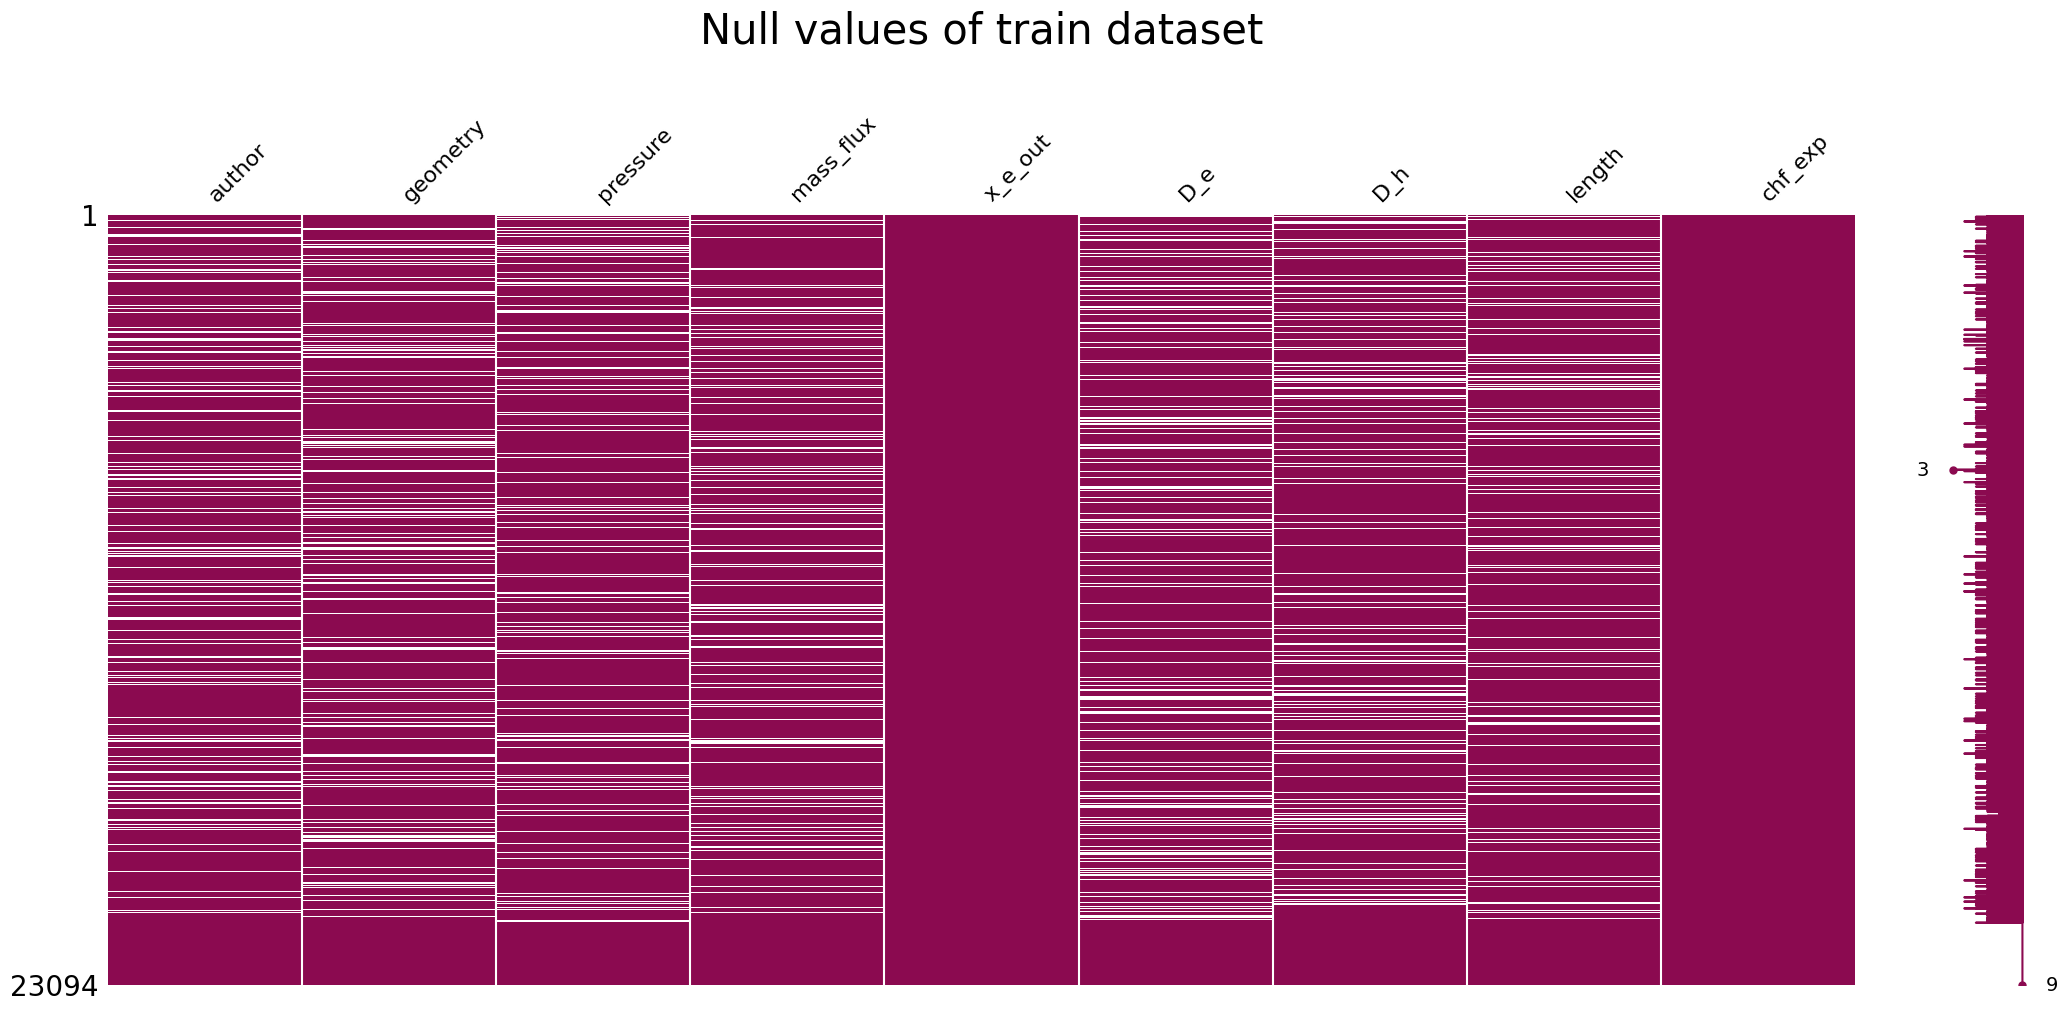

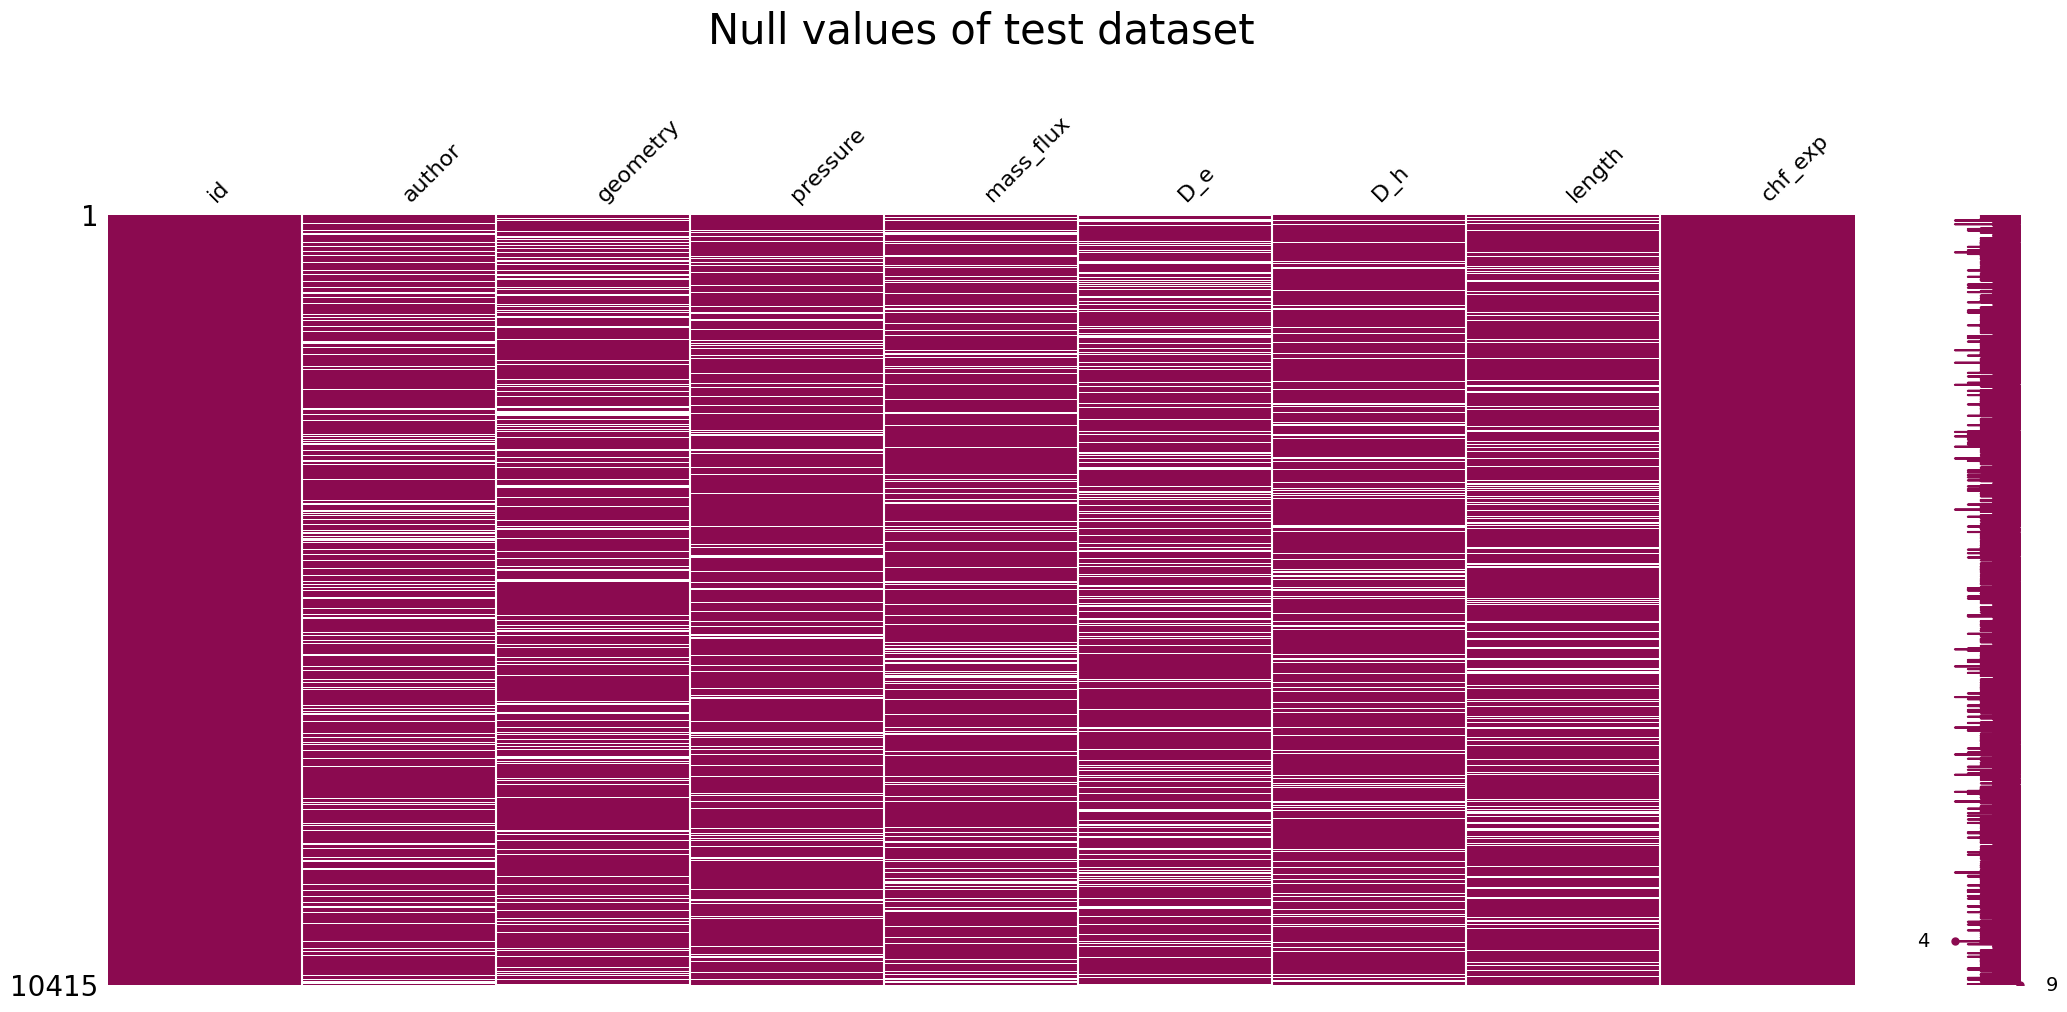

In [10]:
import missingno as msno
msno.matrix(train, color=(139/255,10/255,80/255)).set_title("Null values of train dataset",fontsize=30, pad=50);
msno.matrix(test, color=(139/255,10/255,80/255)).set_title("Null values of test dataset",fontsize=30, pad=50);

# Dealing with NA data in other columns

### Drop all rows with NA

In [11]:
train1 = train.dropna(axis=0).reset_index().drop('index',axis=1)

In [12]:
test1 = test.dropna(axis=0)
test2 = test[~test['id'].isin(test1['id'])]

In [13]:
test1.shape,test2.shape

((3160, 9), (7255, 9))

In [14]:
print('Shape of train dataset before dropping NA is',train.shape)
print('Shape of train dataset after dropping NA is',train1.shape)
print('  Number of rows reduced is', train.shape[0]-train1.shape[0],)
print('Shape of test dataset before dropping NA is',test.shape)
print('Shape of test dataset after dropping NA is',test1.shape)
print('  Number of rows reduced is', test.shape[0]-test1.shape[0])

Shape of train dataset before dropping NA is (23094, 9)
Shape of train dataset after dropping NA is (8403, 9)
  Number of rows reduced is 14691
Shape of test dataset before dropping NA is (10415, 9)
Shape of test dataset after dropping NA is (3160, 9)
  Number of rows reduced is 7255


In [15]:
train1.head()

,author,geometry,pressure,mass_flux,x_e_out,D_e,D_h,length,chf_exp
0,Beus,annulus,13.79,3679.0,-0.0279,5.6,15.2,2134.0,3.0
1,Peskov,tube,12.00,1617.0,0.1228,10.0,10.0,520.0,2.2
2,Thompson,tube,12.07,3255.0,0.0406,1.9,1.9,152.0,2.9
3,Thompson,tube,10.41,2563.0,0.1092,4.6,4.6,229.0,6.8
4,Janssen,annulus,9.68,5615.0,0.0196,12.7,38.1,914.0,2.9


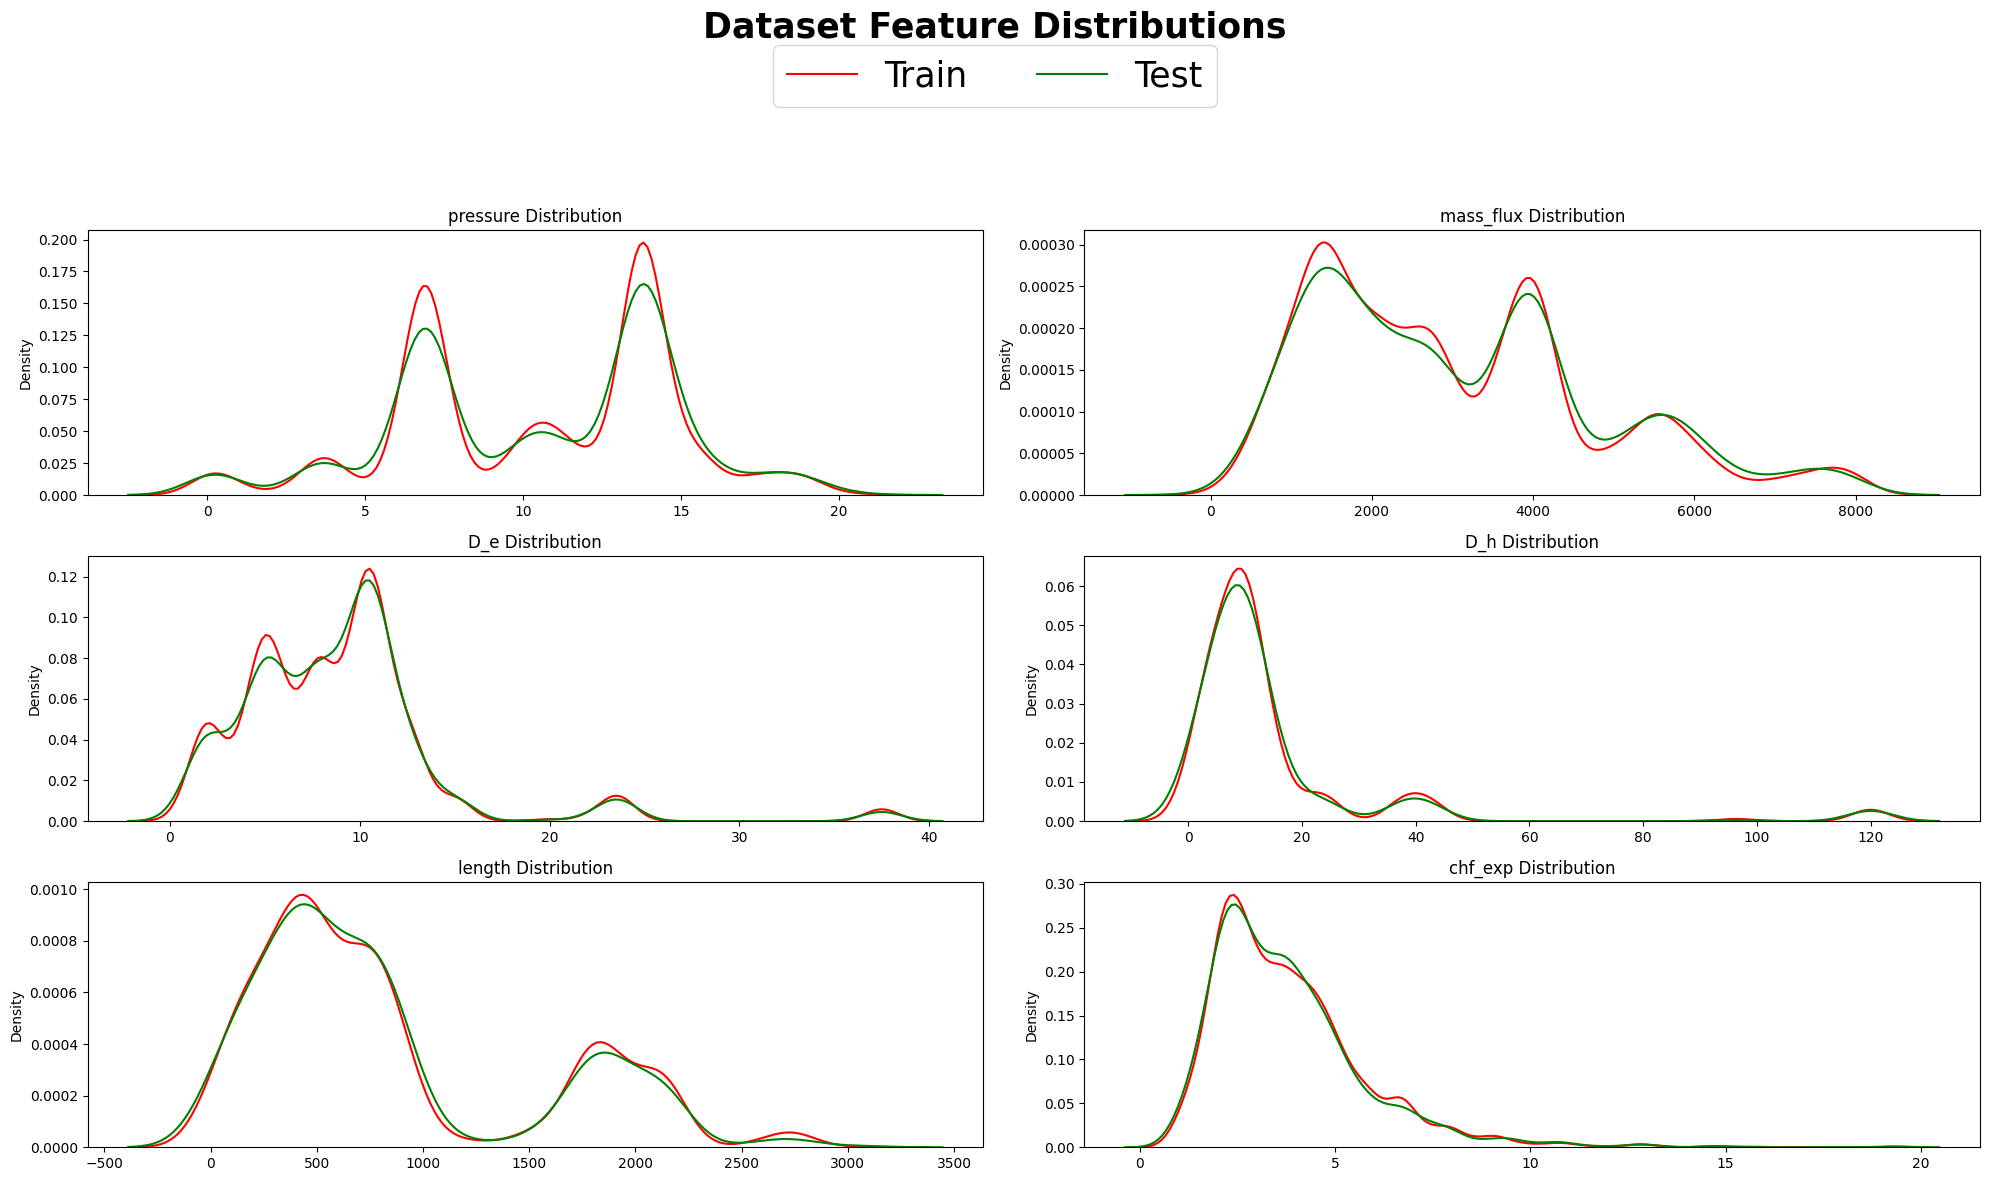

In [16]:
# kudos to @jcaliz
import math
features = ['pressure', 'mass_flux',
       'D_e', 'D_h', 'length',
       'chf_exp']
n_bins = 100
histplot_hyperparams = {
    'kde':True,
    'alpha':0.4,
    'stat':'percent',
    'bins':n_bins
}

columns = features
n_cols = 2
n_rows = math.ceil(len(columns)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
ax = ax.flatten()

for i, column in enumerate(columns):
    plot_axes = [ax[i]]
    sns.kdeplot(
        train1[column], label='Train',
        ax=ax[i], color='r'
    )
    
    sns.kdeplot(
        test1[column], label='Test',
        ax=ax[i], color='g'
    )
    '''
    sns.kdeplot(
        data_origin[column], label='Origin',
        ax=ax[i], color='b'
    )
    '''
    # titles
    ax[i].set_title(f'{column} Distribution');
    ax[i].set_xlabel(None)
    
    # remove axes to show only one at the end
    plot_axes = [ax[i]]
    handles = []
    labels = []
    for plot_ax in plot_axes:
        handles += plot_ax.get_legend_handles_labels()[0]
        labels += plot_ax.get_legend_handles_labels()[1]
        plot_ax.legend().remove()
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')
    
fig.suptitle(f'Dataset Feature Distributions\n\n\n\n', ha='center',  fontweight='bold', fontsize=25)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.965), fontsize=25, ncol=3)
plt.tight_layout()

# Correlation Heatmap

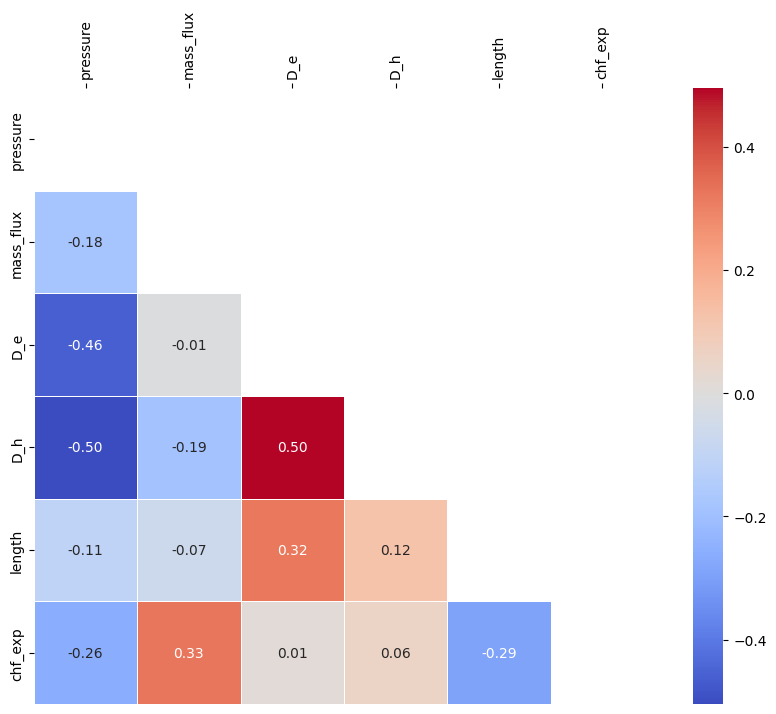

In [17]:
df_corr = train.drop('x_e_out',axis=1)

# Calculate the correlation matrix
correlation_matrix = df_corr.corr()

# Create a mask to hide the upper triangular portion
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the figure size
plt.figure(figsize=(10, 8))

# Plot the correlation heatmap
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', \
            fmt=".2f", linewidths=0.5, annot_kws={"size": 10})

# Adjust the font size of the annotations
plt.tick_params(axis='both', which='both', labelsize=10)

# Change x-axis legend position to top
plt.gca().xaxis.set_ticks_position('top')
plt.xticks(rotation=90)

# Display the heatmap
plt.show()

# One-hot encode categorical features

In [18]:
train2 = train1.copy()
dummyforauthor = pd.get_dummies(train2['author'])
dummyforgeometry = pd.get_dummies(train2['geometry'])
train2 = pd.concat([train2, dummyforauthor, dummyforgeometry], axis=1)\
                    .drop(columns=['author','geometry'],axis=1)


# Build model

In [19]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

X = train2.drop(columns='x_e_out',axis=1)
y = train1['x_e_out']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)
from sklearn.metrics import mean_squared_error

xgb = XGBRegressor(random_state=0).fit(X_train, y_train)
y_pred = xgb.predict(X_valid)
rmse = mean_squared_error(y_pred, y_valid)
print("Root Mean Squared Error:" , rmse)

Root Mean Squared Error: 0.005661374259299305


Notes:  
- Train test split is performed on train dataset to validate the model. 
- The resulting RMSE value is really low. It means that the above model can predict the target quite well given that there is no missing data in other features. 
- What about the portion of test dataset with missing data in other features which makes up most of the test dataset?
- The exact figure for above is 7255 / 10415 = 69.7%! 
- It is assumed that the above model can only predict well for 29.3% of the dataset with complete data in other features.

# Prepare test dataset

Like before, the test dataset will be separated into two subsets, those without NA in other features and those with NA in other features.

The idea is to treat these two subsets separately to maximize the prediction accuracy for the subset with complete feature data, and try to impute the subset with NA in other columns and predict them separately.

In [20]:
test_all = test.copy()
test_dropna = test1.copy()
test_onlyna = test2.copy()

# One-hot encode subset with complete data
dummyforauthor = pd.get_dummies(test_dropna['author'])
dummyforgeometry = pd.get_dummies(test_dropna['geometry'])
test_dropna = pd.concat([test_dropna, dummyforauthor, dummyforgeometry], axis=1)\
                    .drop(columns=['author','geometry'],axis=1)

# Impute categorical data randomly
authorlist = pd.Series(df['author'].unique())
geometrylist = pd.Series(df['geometry'].unique())

np.random.seed(42)
test_onlyna['author'] = test_onlyna['author'].fillna(pd.Series(np.random.choice(authorlist, size=len(test_onlyna), replace=True)))
test_onlyna['geometry'] = test_onlyna['geometry'].fillna(pd.Series(np.random.choice(geometrylist, size=len(test_onlyna), replace=True)))

# One-hot encode subset with missing data
dummyforauthor = pd.get_dummies(test_onlyna['author'])
dummyforgeometry = pd.get_dummies(test_onlyna['geometry'])
test_onlyna = pd.concat([test_onlyna, dummyforauthor, dummyforgeometry], axis=1)\
                    .drop(columns=['author','geometry'],axis=1)

# Impute numerical data using mean strategy
from sklearn.impute import SimpleImputer

cols = ['pressure', 'mass_flux', 'D_e', 'D_h', 'length', 'chf_exp']
imputer = SimpleImputer(strategy='mean')
imputer.fit(test_onlyna[cols])
test_onlyna[cols] = imputer.transform(test_onlyna[cols])

In [21]:
# Combine the two subsets for prediction

test_final = pd.concat([test_dropna, test_onlyna],axis=0).sort_values(by='id', ascending=True).drop('id',axis=1)
print(test_final.shape),
test_final.head()

(10415, 19)


,pressure,mass_flux,D_e,D_h,length,chf_exp,Beus,Inasaka,Janssen,Kossolapov,Mortimore,Peskov,Richenderfer,Thompson,Weatherhead,Williams,annulus,plate,tube
4,13.790000,686.000000,11.100000,11.1,457.0,2.8,0,0,1,0,0,0,0,0,0,0,0,0,1
7,18.000000,750.000000,10.000000,10.0,1650.0,2.2,0,0,0,0,0,1,0,0,0,0,0,0,1
10,10.703797,3045.603409,1.900000,1.9,152.0,3.2,0,0,0,0,0,0,0,1,0,0,0,0,1
12,6.890000,7500.000000,8.665902,12.8,1930.0,4.8,0,0,0,0,0,0,0,1,0,0,1,0,0
23,15.510000,1355.000000,5.600000,15.2,2134.0,2.1,1,0,0,0,0,0,0,0,0,0,1,0,0


# Final Prediction

In [22]:
X_test = test_final
y_final = xgb.predict(X_test)
output = pd.DataFrame({'id': test_id, 'x_e_out [-]': y_final})
print(output.head())

    id  x_e_out [-]
4    4    -0.054741
7    7    -0.064093
10  10    -0.060357
12  12    -0.018443
23  23     0.061673


In [23]:
output.to_csv('submission_v4.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
